In [15]:
from synthcity_addons import generators
import openml
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from synthcity_addons import GenericDataLoader
from utils import TabrQuantileTransformer
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons

#normalization = "tabr_quantile"
normalization = "standard"
task_id = 361073
task = openml.tasks.get_task(task_id)
dataset = task.get_dataset()
dataset_name = dataset.name
# kwargs are the hyperparameters
hp_dic = {}
hp_dic.update({"strict": False})
print("hp_dic", hp_dic)
hp_dic_original = hp_dic.copy()
hp_str = "_".join([f"{k}_{v}" for k, v in hp_dic.items()]) # before it's modified by synthcity
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
# add target to X
X["target"] = y
# restrict X to 20K random samples
if X.shape[0] > 20000:
    X = X.sample(20000, random_state=42)

# restrict to 30 columns
#X = X.iloc[:, -30:]
X = X.iloc[:, :2]


# make a random 2d numerical + categorical
# X = pd.DataFrame(np.random.rand(4000, 2), columns=["x", "y"])
# # make the second column categorical (ordinal 0, 1, 2)
# X["y"] = pd.cut(X["y"], bins=3, labels=[0, 1, 2])
X, y = make_moons(n_samples=3000, noise=0.1)
X = pd.DataFrame(X, columns=["x", "y"])

print(X.columns)
if normalization == "quantile":
    X = QuantileTransformer(output_distribution="normal", random_state=42).set_output(transform="pandas").fit_transform(X)
elif normalization == "standard":
    X = StandardScaler().set_output(transform="pandas").fit_transform(X)
elif normalization == "tabr_quantile":
    X_ = TabrQuantileTransformer().fit_transform(X.to_numpy())
    # transform back to pandas
    X = pd.DataFrame(X_, columns=X.columns)
X.iloc[:, 1] = X.iloc[:, 1] + np.random.normal(0, 0.01, X.shape[0])

print(X)
# take 1024 random rows from X
indices = np.random.choice(X.index, 1024, replace=False)
X_ref = X.loc[indices]
X = X.drop(index=indices)

loader = GenericDataLoader(X, target_column="target")
loader_ref = GenericDataLoader(X_ref, target_column="target")

print("Loaded")

task_type = "regression"
synthetic_size = 512

/storage/store/work/lgrinszt/miniforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/storage/store/work/lgrinszt/miniforge/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/storage/store/work/lgrinszt/miniforge/lib/python3.10/site-package

hp_dic {'strict': False}
Index(['x', 'y'], dtype='object')
             x         y
0    -0.360165 -0.692847
1    -0.745228  1.128938
2    -0.383831 -0.575946
3     1.607580 -0.270120
4    -0.510144  1.470190
...        ...       ...
2995  0.041140  1.173789
2996  0.456790 -1.478434
2997 -0.398875 -0.700469
2998 -1.653362  0.490938
2999 -0.442525 -0.617367

[3000 rows x 2 columns]
Loaded


In [25]:
from synthcity.plugins import Plugins
hp_dic["n_batches"] = 50
hp_dic["n_permutations"] = 5
hp_dic["n_ensembles"] = 5
hp_dic["n_test_from_false_train"] = 256
hp_dic["device"] = "cuda:1"
hp_dic["lr"] = 0.02
hp_dic["store_intermediate_data"] = True
hp_dic["initialization_strategy"] = Plugins().get("smote")
hp_dic["loss"] = "average"
hp_dic["store_animation_path"] = "animation.mp4"
hp_dic["strict"] = "False"
plugin = Plugins().get("tabpfn_points", **hp_dic)

[2024-07-08T20:08:03.598064+0200][11599][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py
[2024-07-08T20:08:03.617638+0200][11599][CRITICAL] module disabled: /storage/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


In [26]:
#plugin = Plugins().get("ddpm", n_iter=20, num_timesteps=10)#, **{"num_timesteps": 10, "sampling_patience": 40})

encoders None
encoders None


  2%|▏         | 1/50 [00:03<02:59,  3.66s/it]

Batch 0 loss: 3.403153314707197e-10


 22%|██▏       | 11/50 [00:40<02:22,  3.66s/it]

Batch 10 loss: 6.959579934573412e-08


 42%|████▏     | 21/50 [01:16<01:46,  3.66s/it]

Batch 20 loss: 9.20327014597433e-09


 62%|██████▏   | 31/50 [01:53<01:09,  3.67s/it]

Batch 30 loss: 9.002987155781739e-08


 82%|████████▏ | 41/50 [02:30<00:32,  3.67s/it]

Batch 40 loss: 5.4997038034798607e-08


100%|██████████| 50/50 [03:03<00:00,  3.66s/it]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y animation.mp4


animation done


(tensor([[0.4920, 0.5080],
         [0.5020, 0.4980],
         [0.5019, 0.4981],
         ...,
         [0.4950, 0.5050],
         [0.4989, 0.5011],
         [0.5028, 0.4972]]),
 tensor([[ 0.5374, -1.3795],
         [ 1.3896, -0.6654],
         [-0.4280,  0.1592],
         ...,
         [ 0.8602, -1.2085],
         [-0.4018, -0.1820],
         [-0.3816,  0.0716]]),
 tensor([0, 0, 1,  ..., 1, 1, 1]))

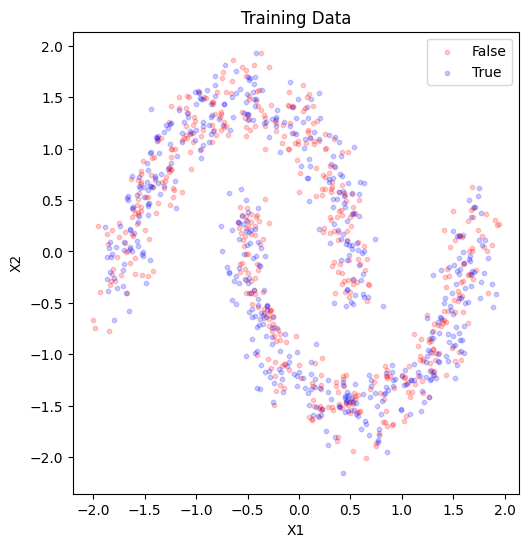

In [27]:
plugin.fit(X)

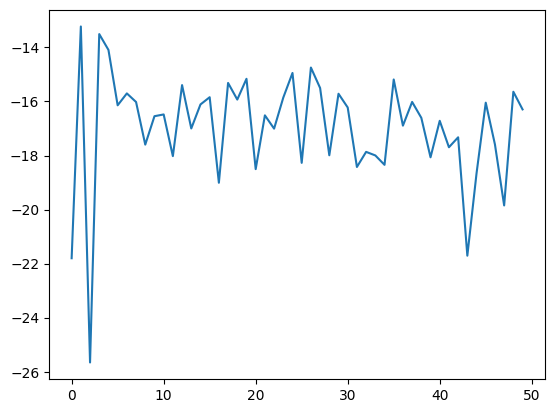

In [34]:
plt.plot(np.log(plugin.loss_list))

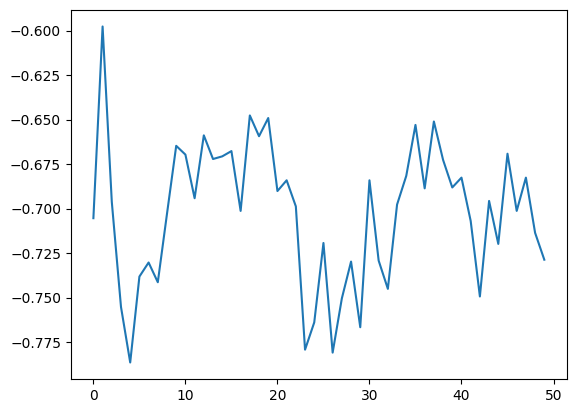

In [35]:
plt.plot(np.log(plugin.accuracy_list))

In [29]:
X_false_tabpfn = plugin.generate(512).numpy()

In [30]:
#X_false = plugin.generate(512).numpy()

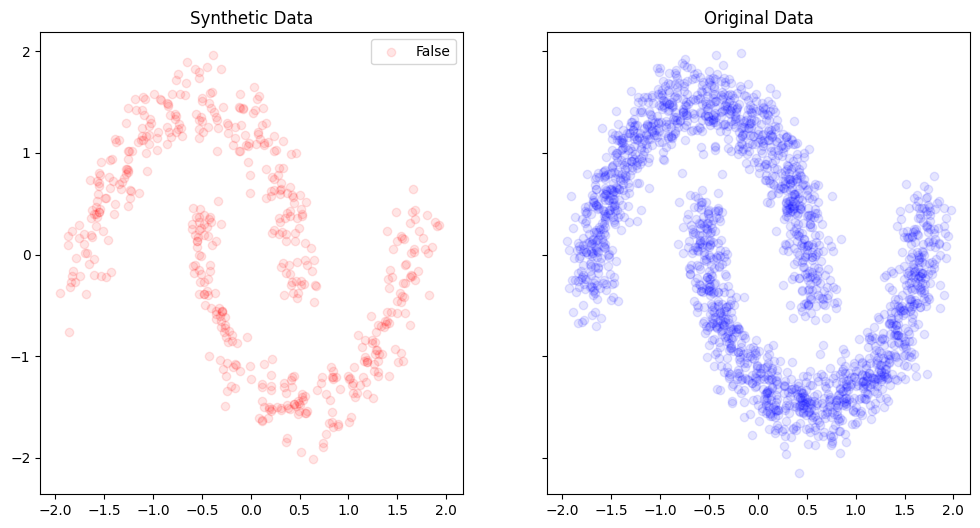

In [31]:
import matplotlib.pyplot as plt
dims = 0, 1
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

ax1.scatter(X_false_tabpfn[:, dims[0]], X_false_tabpfn[:, dims[1]], color="red", label="False", alpha=0.1)
ax1.set_title("Synthetic Data")
ax1.legend()

ax2.scatter(X.to_numpy()[:, dims[0]], X.to_numpy()[:, dims[1]], color="blue", alpha=0.1)
ax2.set_title("Original Data")

plt.show()


In [58]:
X.iloc[:, 1]

1       -1.005933
2        0.093370
3        1.351329
4        1.130121
6       -1.000434
           ...   
14995    0.998601
14996    1.681988
14997   -1.002404
14998    1.062253
14999    0.720341
Name: f6, Length: 13976, dtype: float64

In [59]:
X_false_tabpfn[:, 1]

array([ 3.97222749e-01, -1.01234369e+00, -1.00765852e+00,  3.71943218e-01,
        2.55448434e-01,  1.62346473e+00,  1.63138673e+00, -1.94936174e-01,
       -2.65921626e-01,  1.63909423e+00,  3.54560274e-01, -1.02174839e+00,
       -4.17036851e-01, -1.00395244e+00, -1.28131837e-01,  6.82279678e-01,
        1.14962230e+00,  8.07481759e-01, -9.96888704e-01,  1.86228439e+00,
        7.17192760e-01,  6.51849521e-01,  1.60198304e+00,  1.84901916e-01,
       -9.95818239e-01,  1.03942146e+00, -1.01245117e+00,  6.07591613e-01,
        1.86023763e+00, -1.01770865e+00, -1.01669999e+00,  6.40583122e-01,
       -1.01360526e+00, -1.62378759e-01, -4.32797006e-01, -1.12004442e-01,
        1.39385557e-01, -1.01695559e+00, -3.63612324e-01, -1.01683508e+00,
       -1.99458861e-01, -1.00821219e+00, -1.00213544e+00,  1.97890438e+00,
        8.97484331e-01, -9.99566815e-01,  8.83287786e-01, -1.01717086e+00,
        1.12191070e+00, -1.25994630e-01,  1.25192961e-01,  5.18226948e+00,
       -3.10896079e-01,  

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Model accuracy: 0.5121951219512195


(array([[10.,  6.,  7.,  1.,  2.,  1.,  2.,  0.,  3.,  1.,  2.,  1.,  0.,
          1.,  0.,  2.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,  0.,  2.,  0.,
          0.,  4.,  3.,  0.,  3.,  6.,  3.,  1.,  2.,  1.,  1.,  3.,  2.,
          2.,  1.,  3.,  1.,  0.,  1.,  1.,  3.,  1.,  1.,  0.,  1.,  2.,
          1.,  2.,  1.,  4.,  5.,  3.,  0.,  1.,  3.,  3.,  1.,  2.,  6.,
          2.,  3.,  3.,  3.,  3.,  4.,  8.,  3.,  3.,  7.,  1.,  4.,  5.,
          4.,  3.,  2.,  1.,  4.,  3.,  4.,  4.,  2.,  1.,  2.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,
          2.,  4.,  4.,  3.,  4.,  1.,  2.,  3.,  4.,  5.,  4.,  1.,  7.,
          3.,  3.,  8.,  4.,  3.,  3.,  3.,  3.,  2.,  6.,  2.,  1.,  3.,
          3.,  1.,  0.,  3.,  5.,  4.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,
          1.,  3.,  1.,  1.,  0.,  1.,  3.,  1.,  2.,  2.,  3.,  1.,  1.,
          2.,  1.,  3.,  6.,  3.,  0.,  3.,  4.,  0.,  0.

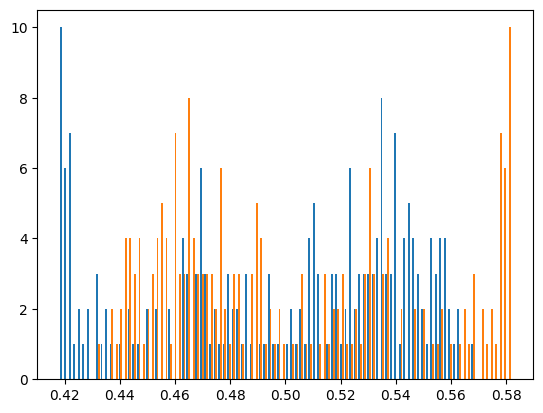

In [43]:
from tabpfn import TabPFNClassifier

model = TabPFNClassifier(normalize=False, no_preprocess_mode=True)
#model = TabPFNClassifier()

# Train the model to see if it can discriminate between true and false data
y_true = np.ones(X_false_tabpfn.shape[0])
y_false = np.zeros(X_false_tabpfn.shape[0])

X_combined = np.vstack((X.to_numpy()[:X_false_tabpfn.shape[0]], X_false_tabpfn))
y_combined = np.hstack((y_true, y_false))

# train test split
from sklearn.model_selection import train_test_split

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

# show the proba distribution
probs = model.predict_proba(X_test)
plt.hist(probs, bins=100)



NORMALIZING
NORMALIZING
Model accuracy: 0.4926829268292683
NORMALIZING
NORMALIZING


(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  5.,  0.,  2.,
          1.,  1.,  3.,  4.,  5.,  7., 18., 16., 10., 10.,  9., 17., 17.,
         14.,  7.,  7.,  7.,  6.,  4.,  5.,  3.,  0.,  3.,  1.,  1.,  3.,
          0.,  1.,  2.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          2.,  0.,  0.,  1.,  0.,  2.,  2.,  1.,  0.,  3.,  1.,  1.,  3.,
          0.,  3.,  5.,  4.,  6.,  7.,  7.,  7., 14., 17., 17.,  9., 10.,
         10., 16., 18.,  7.,  5.,  4.,  3.,  1.,  1.,  2.,  0.,  5.,  3.,
          2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

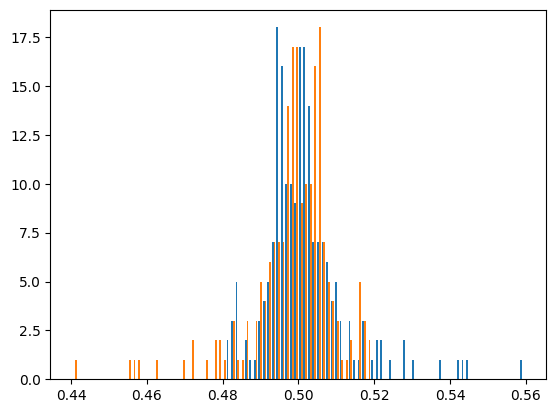

In [44]:
from tabpfn import TabPFNClassifier

#model = TabPFNClassifier(normalize=False, no_preprocess_mode=True)
model = TabPFNClassifier()

# Train the model to see if it can discriminate between true and false data
y_true = np.ones(512)
y_false = np.zeros(512)

X_combined = np.vstack((X.to_numpy()[:512], X_ref.to_numpy()[:512]))
y_combined = np.hstack((y_true, y_false))

# train test split
from sklearn.model_selection import train_test_split

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

# show the proba distribution
probs = model.predict_proba(X_test)
plt.hist(probs, bins=100)



In [ ]:
import matplotlib.pyplot as plt
dims = 0, 1
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

ax1.scatter(X_false[:, dims[0]], X_false[:, dims[1]], color="red", label="False", alpha=0.5)
ax1.set_title("Synthetic Data")
ax1.legend()

ax2.scatter(X.to_numpy()[:, dims[0]], X.to_numpy()[:, dims[1]], color="blue", alpha=0.1)
ax2.set_title("Original Data")

plt.show()


In [ ]:
plt.scatter(X_false[:, dims[0]], X_false[:, dims[1]], color="red", label="False", alpha=0.5)

In [ ]:
plt.hist(X.to_numpy()[:, dims[0]])

In [ ]:
num_unique_rows = len(np.unique(plugin.X_false_train.cpu().detach().numpy(), axis=0))
print(f"Number of unique rows in X_false: {num_unique_rows}")

In [ ]:
from synthcity_addons import generators
import numpy as np
from synthcity_addons import GenericDataLoader, Plugins

# change seed
np.random.seed(20)

X = np.random.rand(10, 2)
X_ref = np.random.rand(10, 2)

loader = GenericDataLoader(X)
loader_ref = GenericDataLoader(X_ref)

syn_model = Plugins().get("oracle", strict=False)
syn_model.fit(loader, loader_ref)

false_data = syn_model.generate(14)
# show the number of duplicates in false_data
s = 0
for i in range(false_data.numpy().shape[0]):
    for j in range(i+1, false_data.numpy().shape[0]):
        if np.all(false_data.numpy()[i] == false_data.numpy()[j]):
            s += 1
print(s)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(false_data.numpy()[:, 0], false_data.numpy()[:, 1], color="red", label="False", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color="blue", label="True", alpha=0.5)
plt.scatter(X_ref[:, 0], X_ref[:, 1], color="green", label="True", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(false_data.numpy()[:, 0], false_data.numpy()[:, 1], color="red", label="False", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], color="blue", label="True", alpha=0.5)
plt.legend()
plt.show()